In [6]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [7]:
mb_keys_dict = {
    'crop': np.array([18,19,39,20,40,62,41,36,46,47,35,48]),
    'forest': np.array([3]),
    'savanna': np.array([4]),
    'grassland':np.array([12]),
    'pasture': np.array([15])
}

In [8]:
def read_process_lulc_csv(csv):
    df = pd.read_csv(csv, index_col=0)
    df = df.loc[:, df.columns[-1]]
    lulc_y = int(df.name[42:46]) # For all of mato grosso

    df = pd.DataFrame(list(df.apply(eval).values), index=df.index)
    df.columns = pd.MultiIndex.from_product([[lulc_y], df.columns])
    return df

def summarize_lulc(year_df):
    out_df = pd.DataFrame()
    for lulc_class in mb_keys_dict.keys():
        sum_of_class = year_df.loc[:, np.in1d(year_df.columns, mb_keys_dict[lulc_class])].sum(axis=1)
        out_df[lulc_class] = sum_of_class
    return out_df

def classify_lulc(lulc_counts_df):

    natural_covers = ['forest', 'grassland', 'savanna']
    ag_covers = ['crop','pasture']
    natural_df = lulc_counts_df[natural_covers]
    ag_df = lulc_counts_df[ag_covers]
    ag_sum = ag_df.sum(axis=1)
    natural_sum = natural_df.sum(axis=1)
    is_natural = ((ag_sum < 1000) & (natural_sum> 1000))
    natural_cover = natural_df.loc[is_natural].idxmax(axis=1)
    is_ag = ((~is_natural) & (ag_sum > 1000))
    ag_cover = ag_df.loc[is_ag].idxmax(axis=1)
    lulc_counts_df['class'] = 'other'
    lulc_counts_df.loc[is_ag, 'class'] = ag_cover
    lulc_counts_df.loc[is_natural, 'class'] = natural_cover
    return lulc_counts_df['class']

def calc_lulc_full(df):
    new_df = pd.DataFrame(df.index).set_index('id_in_tile')

    for y in df.columns.levels[0]:
        year_df = summarize_lulc(df[y])
        year_df.index = df.index
        classes = classify_lulc(year_df)
        new_df.loc[:, y] = classes
        
    return new_df

def process_year_lulc(y):
    all_csvs = glob.glob('./out/lulc_res_counts/lulc_stats_res_{}_mb_*_counts.csv'.format(y))
    all_csvs.sort()
    areas = pd.read_csv(all_csvs[0])['area']
    full_df = pd.concat([read_process_lulc_csv(csv) for csv in all_csvs], axis=1)
    lulc_df = calc_lulc_full(full_df)
    lulc_df['area'] = areas
    return lulc_df

In [9]:
year_range = np.arange(1985, 2022)

for y in year_range:
    lulc_y_csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(y)
    if not os.path.isfile(lulc_y_csv):
        lulc_y_df = process_year_lulc(y)
        lulc_y_df.to_csv('./out/res_lulc_processed/res_lulc_{}.csv'.format(y))
    print(y)


1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


# Helper functions/data for calculating years since/before transitions

In [80]:
lulc_transitions_area_df = pd.read_csv('./out/lulc_summaries/lulc_transitions_yearof_only.csv')
lulc_transitions_area_df['year'] = lulc_transitions_area_df['year'].astype(int)
lulc_transitions_area_df = lulc_transitions_area_df.drop(columns=['Unnamed: 0']).set_index('year')
# Convert areas to km2
lulc_transitions_area_df = lulc_transitions_area_df * 30 * 30 / 1000000

In [134]:

def get_transition_counts(lulc_df, res_y, 
                          only_to_next_transition=True, only_permanent_transition=False,
                          trans_area_df=None, adjust_for_lulc_area=True):
    transition_counts = []
    for y in range(1985, 2022):
        transition_df = lulc_df.loc[lulc_df[y]!=lulc_df[y+1]]
        if only_permanent_transition:
            # only count transitions that match current type and remained that way all along
            if res_y <= y:
                # Transition is in the future
                transition_df = transition_df.loc[
                    np.all(transition_df.loc[:, res_y:y].eq(transition_df[res_y].values, axis=0), axis=1)
                    ]
            if res_y > y:
                # Transition is in the past
                transition_df = transition_df.loc[
                    np.all(transition_df.loc[:, y+1:res_y].eq(transition_df[res_y].values, axis=0), axis=1)
                ]
        elif only_to_next_transition:
            # only count transitions that match current type
            if res_y <= y:
                # Transition is in the future
                transition_df = transition_df.loc[transition_df[y]==transition_df[res_y]]
            if res_y > y:
                # Transition is in the past
                transition_df = transition_df.loc[transition_df[y+1]==transition_df[res_y]]
        
        transition_df['trans_type'] = transition_df[y] + '-' + transition_df[y+1]
        trans_summaries = transition_df[['area','trans_type']].groupby('trans_type').aggregate(
            ['count', 'sum'])
        trans_summaries.name = y
        if adjust_for_lulc_area:
            # Fill in 0s for no reservoir transitions
            missing_transitions = trans_area_df.columns[~trans_area_df.columns.isin(trans_summaries.index)]
            for missing in missing_transitions:
                trans_summaries.loc[missing] = 0
            trans_summaries = trans_summaries.loc[trans_area_df.columns]
            trans_summaries.columns = trans_summaries.columns.set_levels([y],level=0)
            trans_summaries[(y, 'count')] = trans_summaries[(y,'count')]/trans_area_df.loc[y]
            trans_summaries[(y,'sum')] = trans_summaries[(y,'sum')]/trans_area_df.loc[y]
            trans_summaries.columns = trans_summaries.columns.reorder_levels([1,0])
        transition_counts.append(trans_summaries)
    full_year_transitions = pd.concat(transition_counts, axis=1)
    return full_year_transitions

# First for all 7 types of transitions

In [135]:
normalized_dfs_sum = []
normalized_dfs_count = []
for res_y in year_range:
    csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(res_y)
    lulc_df = pd.read_csv(csv).set_index('id_in_tile')
    lulc_df.columns = list(lulc_df.columns[:-1].astype(int)) + [lulc_df.columns[-1]]
    transition_df = get_transition_counts(lulc_df, res_y, only_to_next_transition=True, only_permanent_transition=True,
                                          trans_area_df=lulc_transitions_area_df, adjust_for_lulc_area=True)
    trans_df_count = transition_df['count'].T
    trans_df_count.index = (res_y+1) - trans_df_count.index
    trans_df_sum = transition_df['sum'].T
    trans_df_sum.index = (res_y+1) - trans_df_sum.index
    trans_df_sum.name=res_y
    trans_df_count.name=res_y
    normalized_dfs_sum.append(trans_df_sum)
    normalized_dfs_count.append(trans_df_count)

      forest-pasture  forest-crop  savanna-pasture  savanna-crop  \
1985        0.005325     0.000000         0.059066      0.148030   
1986        0.008812     0.000000         0.044337      0.017733   
1987        0.005479     0.013250         0.050914      0.041874   
1988        0.002285     0.021248         0.018969      0.024026   
1989        0.001908     0.000000         0.024660      0.008773   
1990        0.002741     0.000000         0.023435      0.010911   
1991        0.000864     0.000000         0.015032      0.010492   
1992        0.001166     0.000000         0.009009      0.005022   
1993        0.001441     0.000000         0.011149      0.007054   
1994        0.000000     0.000000         0.011208      0.007003   
1995        0.000525     0.000000         0.009635      0.000000   
1996        0.000650     0.000000         0.004338      0.003839   
1997        0.000948     0.000000         0.003904      0.000000   
1998        0.001255     0.000000         0.0050

In [136]:
full_normalized_df = pd.concat(normalized_dfs_count)
mean_trajectories = full_normalized_df.groupby(level=0).mean()
std_trajectories = full_normalized_df.groupby(level=0).std()
count_trajectories = full_normalized_df.groupby(level=0).count()

In [137]:

rename_dict = {
        'forest-pasture': 'Forest-Pasture',
        'grassland-pasture':'Grassland-Pasture',
        'savanna-pasture':'Savanna-Pasture',
        'forest-crop': 'Forest-Crop',
        'grassland-crop':'Grassland-Crop',
        'savanna-crop':'Savanna-Crop',
        'pasture-crop':'Pasture-Crop',
    }

In [138]:
mean_trajectories = mean_trajectories.rename(
    columns=rename_dict
)
std_trajectories = std_trajectories.rename(
    columns=rename_dict
)

In [139]:
top_traj = mean_trajectories + std_trajectories
bottom_traj = mean_trajectories - std_trajectories

Text(0, 0.5, 'Transition Area ($km^2$)')

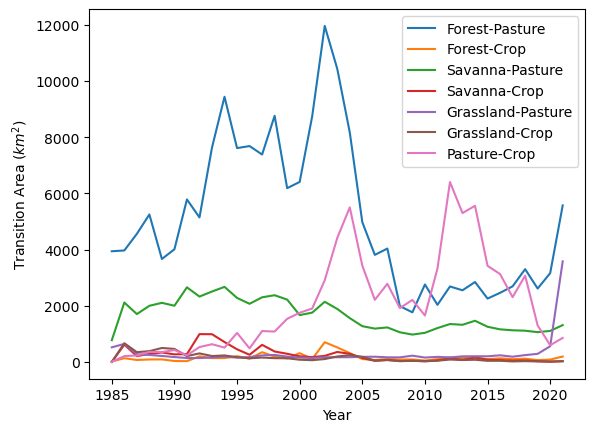

In [140]:
ax = lulc_transitions_area_df.rename(columns=rename_dict).plot()
ax.set_xlabel('Year')
ax.set_ylabel('Transition Area ($km^2$)')

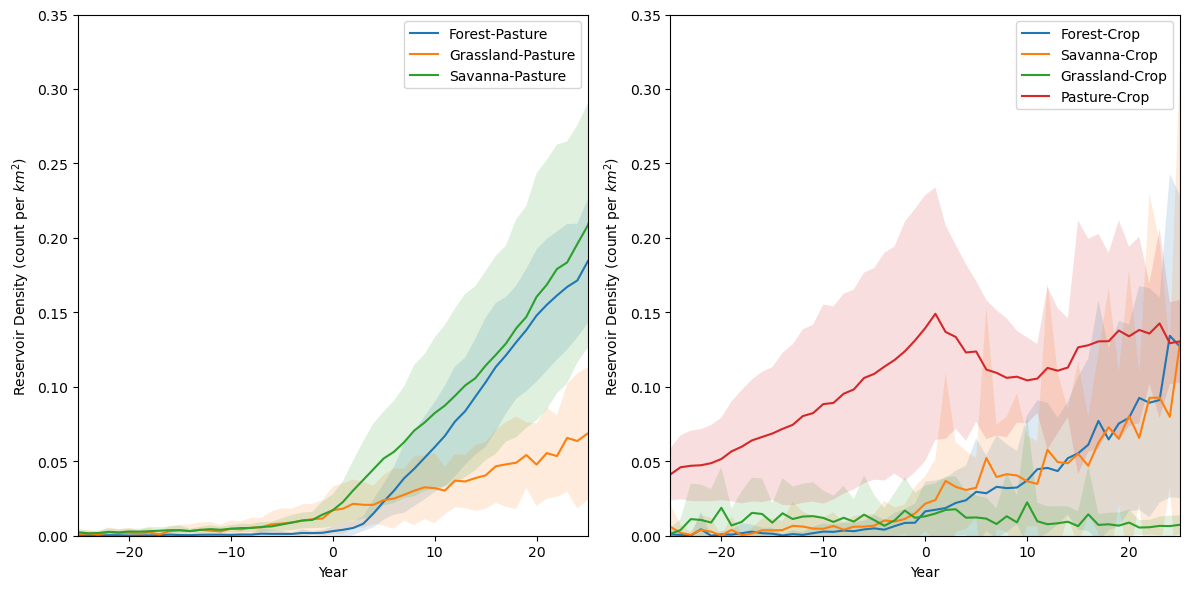

In [141]:

# Together
fig, axs = plt.subplots(1,2, figsize=(12,6))
mean_traj_toplot = mean_trajectories[['Forest-Pasture','Grassland-Pasture', 'Savanna-Pasture']]
mean_traj_toplot.plot(xlim=[-25, 25],ylim=[0,0.35], ax=axs[0])
for cover_type in mean_traj_toplot.columns:
    axs[0].fill_between(mean_traj_toplot.index,
                        bottom_traj[cover_type], top_traj[cover_type], alpha=0.15)
mean_traj_toplot = mean_trajectories[['Forest-Crop','Savanna-Crop',  'Grassland-Crop', 'Pasture-Crop']]
mean_traj_toplot.plot(xlim=[-25, 25], ylim=[0,0.35], ax=axs[1])
for cover_type in mean_traj_toplot.columns:
    axs[1].fill_between(mean_traj_toplot.index,
                        bottom_traj[cover_type], top_traj[cover_type], alpha=0.15)
axs[0].set_xlabel('Year')
axs[1].set_xlabel('Year')
axs[0].set_ylabel('Reservoir Density (count per $km^2$)')
axs[1].set_ylabel('Reservoir Density (count per $km^2$)')
fig.tight_layout()
plt.show()

# Simplify: Nature, Pasture, Crop

In [142]:
transition_regroup_dict = {
    'Natural-Pasture': ['forest-pasture', 'savanna-pasture','grassland-pasture'],
    'Natural-Crop': ['forest-crop', 'savanna-crop','grassland-crop'],
    'Pasture-Crop': ['pasture-crop'],
}

lulc_transitions_area_simple_df = pd.DataFrame({'year':lulc_transitions_area_df.index}).set_index('year')
for key, val in transition_regroup_dict.items():
    lulc_transitions_area_simple_df.loc[:, key] = lulc_transitions_area_df[val].sum(axis=1)

In [143]:
# Group trajectories into nature, crop, pasture
regroup_dict = {
    'pasture': 'Pasture',
    'forest': 'Natural',
    'savanna': 'Natural',
    'grassland': 'Natural',
    'crop': 'Crop'
}

normalized_dfs_simple_sum = []
normalized_dfs_simple_count = []
for res_y in year_range:
    csv = './out/res_lulc_processed/res_lulc_{}.csv'.format(res_y)
    lulc_df = pd.read_csv(csv).set_index('id_in_tile').replace(regroup_dict)
    lulc_df.columns = list(lulc_df.columns[:-1].astype(int)) + [lulc_df.columns[-1]]
    transition_df = get_transition_counts(lulc_df, res_y, only_to_next_transition=True,only_permanent_transition=True,
                                          trans_area_df=lulc_transitions_area_simple_df, adjust_for_lulc_area=True)
    trans_df_count = transition_df['count'].T
    trans_df_count.index = (res_y+1) - trans_df_count.index
    trans_df_sum = transition_df['sum'].T
    trans_df_sum.index = (res_y+1) - trans_df_sum.index
    trans_df_sum.name=res_y
    trans_df_count.name=res_y
    normalized_dfs_simple_sum.append(trans_df_sum)
    normalized_dfs_simple_count.append(trans_df_count)


In [144]:
simple_full_normalized_df = pd.concat(normalized_dfs_simple_count)
simple_mean_trajectories = simple_full_normalized_df.groupby(level=0).mean()
simple_std_trajectories = simple_full_normalized_df.groupby(level=0).std()
simple_count_trajectories = simple_full_normalized_df.groupby(level=0).count()

/tmp/ipykernel_647622/2756076753.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 1500x500 with 0 Axes>

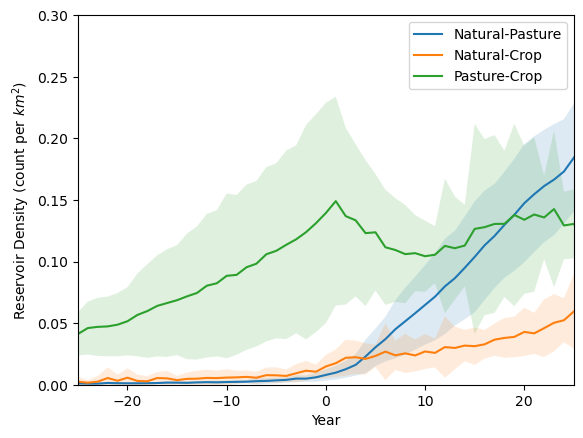

In [145]:
fig = plt.figure(figsize=(15, 5))
ax = simple_mean_trajectories.plot(xlim=[-25, 25],ylim=[0,0.30])
for cover_type in simple_mean_trajectories.columns:
    ax.fill_between(simple_mean_trajectories.index,
                    (simple_mean_trajectories - simple_std_trajectories)[cover_type],
                    (simple_mean_trajectories + simple_std_trajectories)[cover_type],
                    alpha=0.15)
ax.set_xlabel('Year')
ax.set_ylabel('Reservoir Density (count per $km^2$)')
fig.show()

Text(0, 0.5, 'Transition Area ($km^2$)')

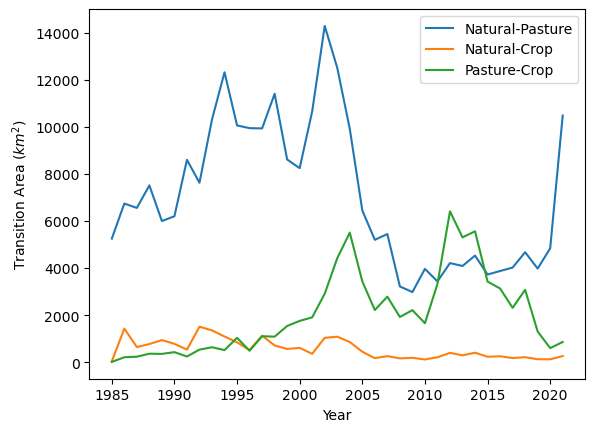

In [102]:
ax = lulc_transitions_area_simple_df.rename(columns=rename_dict).plot()
ax.set_xlabel('Year')
ax.set_ylabel('Transition Area ($km^2$)')

# LULC fig

In [36]:
annual_lulc = pd.read_csv('./csvs/lulc_summary_mt.csv').set_index('year')
annual_lulc*= (900/1000000)
annual_lulc['Total Agricultural'] = annual_lulc['pasture'] +  annual_lulc['crop']
annual_lulc.rename(columns={'pasture': 'Pasture', 'crop': 'Crop'}, inplace=True)

In [39]:
yearof_res_list = []
for res_y in range(1985, 2022):
    yearof_res_list.append(pd.read_csv('./out/res_lulc_processed/res_lulc_{}.csv'.format(res_y))[str(res_y)])

In [40]:
yearof_counts_by_lulc = [df.value_counts() for df in yearof_res_list]

In [41]:
annual_res_lulc = pd.concat(yearof_counts_by_lulc, axis=1).T

In [42]:
annual_res_lulc = annual_res_lulc#.drop(columns=['other', 'forest'])
annual_res_lulc = annual_res_lulc.rename(columns={'crop': 'Crop','pasture':'Pasture'})
annual_res_lulc['Total Agricultural'] = annual_res_lulc['Crop'] + annual_res_lulc['Pasture']
annual_res_lulc.columns.name = None

In [43]:
annual_res_lulc_density = annual_res_lulc[['Total Agricultural', 'Pasture', 'Crop']]/annual_lulc[['Total Agricultural', 'Pasture', 'Crop']].loc[:2021].values

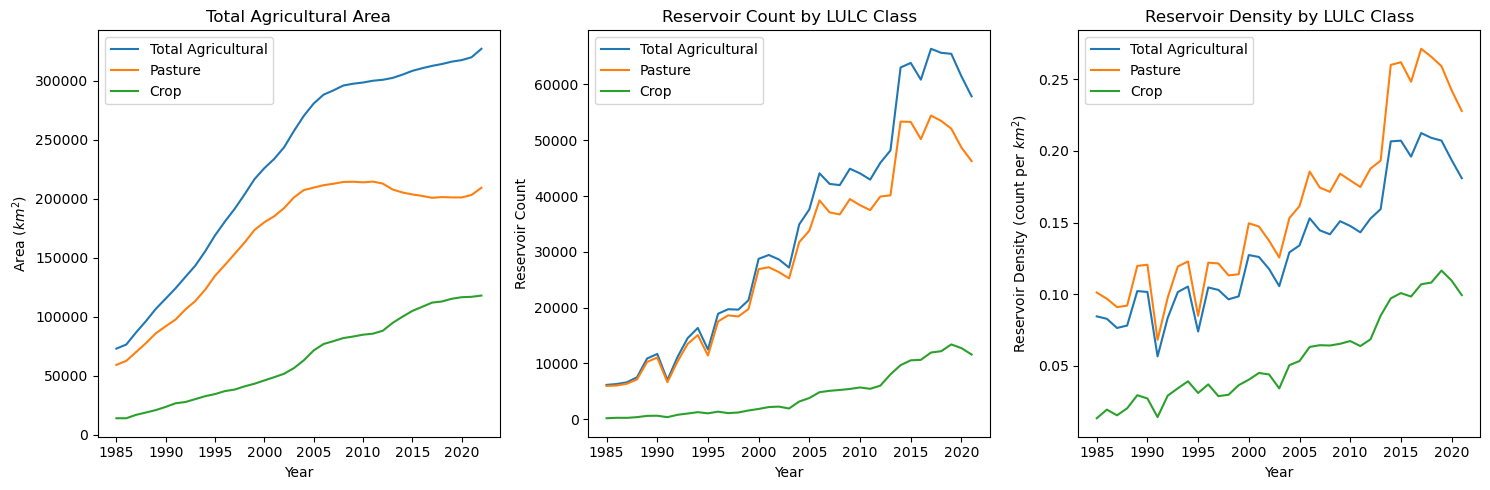

In [47]:
# Together
fig, axs = plt.subplots(1,3, figsize=(15,5))
annual_res_lulc[['Total Agricultural', 'Pasture', 'Crop']].plot(ax=axs[1])
annual_lulc[['Total Agricultural', 'Pasture', 'Crop']].plot(ax=axs[0])
annual_res_lulc_density[['Total Agricultural', 'Pasture', 'Crop']].plot(ax=axs[2])
axs[0].set_xlabel('Year')
axs[1].set_xlabel('Year')
axs[2].set_xlabel('Year')
axs[0].set_ylabel('Area ($km^2$)')
axs[1].set_ylabel('Reservoir Count')
axs[2].set_ylabel('Reservoir Density (count per $km^2$)')
axs[0].set_title('Total Agricultural Area')
axs[1].set_title('Reservoir Count by LULC Class')
axs[2].set_title('Reservoir Density by LULC Class')
fig.tight_layout()
plt.show()